In [1]:
# CELL 1 (AFTER FACTORY RESET)

# Install necessary libraries
# Increased timeout for pip potentially helpful for large downloads like torch
!pip config set global.timeout 600

# Install libraries, letting pip resolve compatible versions where possible initially.
# Pin only faiss-cpu as it was the only one *not* causing direct conflicts initially.
!pip install -q \
    transformers \
    sentence-transformers \
    huggingface-hub \
    tokenizers \
    faiss-cpu==1.7.4 \
    torch \
    accelerate \
    scikit-learn \
    pandas \
    matplotlib \
    protobuf

# Note: Minimal pinning strategy for a fresh environment. Let pip try to sort it out.

Writing to /root/.config/pip/pip.conf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.

In [2]:
import json
import os
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartForSequenceClassification,
    BartTokenizer,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, hamming_loss
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use notebook version of tqdm
import logging
import re
from typing import List, Dict, Tuple, Optional
import pickle
import gc # Garbage collector

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

2025-04-10 14:59:47.233766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744297187.463902      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744297187.529408      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# --- Hyperparameters ---
MAX_LEN = 512  # Increased for combined prompts
BATCH_SIZE = 8  # Smaller batch size due to longer sequences (Adjust based on GPU memory)
NUM_EPOCHS = 20 # Can be overridden later
LEARNING_RATE = 3e-5
EMBEDDING_DIM = 1024  # For BAAI/bge-m3
RETRIEVAL_K = 3  # Number of examples to retrieve
ADAM_BETA1 = 0.9
ADAM_BETA2 = 0.999
ADAM_EPSILON = 1e-8
WEIGHT_DECAY = 0.01
DROPOUT = 0.1

# --- Kaggle File Paths ---
# !!! ADJUST 'mental-health-meme-datasets' to your actual Kaggle dataset name !!!
KAGGLE_INPUT_DIR = "/kaggle/input/axiom-dataset"
KAGGLE_WORKING_DIR = "/kaggle/working"

# --- Output Directory Setup ---
# Will be set dynamically based on dataset choice later
# Example: OUTPUT_DIR = os.path.join(KAGGLE_WORKING_DIR, "anxiety", "output", "knowledge_fusion")

# --- Seed ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    logger.info(f"Seed set to {seed}")

set_seed(42)

# --- Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

In [4]:
def load_data(file_path):
    """Load data from JSON file for both anxiety and depression datasets"""
    logger.info(f"Loading data from: {file_path}")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        return []
    except json.JSONDecodeError:
         logger.error(f"Error decoding JSON from: {file_path}")
         return []

    # Detect dataset type based on file path
    is_anxiety = "Anxiety_Data" in file_path

    filtered_data = []
    processed_ids = set() # Keep track of processed IDs to avoid duplicates if any

    for sample in data:
        # Ensure sample is a dictionary
        if not isinstance(sample, dict):
            logger.warning(f"Skipping non-dictionary item in {file_path}")
            continue

        sample_id = sample.get('sample_id', sample.get('id', None)) # Handle potential variations in ID field

        # Skip duplicates
        if sample_id is not None and sample_id in processed_ids:
            logger.warning(f"Skipping duplicate sample ID: {sample_id}")
            continue
        if sample_id is not None:
             processed_ids.add(sample_id)


        # Anxiety dataset processing
        if is_anxiety:
            if 'ocr_text' in sample and 'meme_anxiety_category' in sample:
                # Fix the misspelled "Irritatbily" to "Irritability"
                if sample['meme_anxiety_category'] == 'Irritatbily':
                    sample['meme_anxiety_category'] = 'Irritability'
                # Change "Unknown" to "Unknown Anxiety"
                elif sample['meme_anxiety_category'] == 'Unknown':
                    sample['meme_anxiety_category'] = 'Unknown Anxiety'

                # Ensure triples exists, default to empty string if not
                if 'triples' not in sample or sample['triples'] is None:
                    sample['triples'] = ""

                filtered_data.append(sample)
            else:
                 logger.warning(f"Skipping anxiety sample due to missing fields: {sample.get('sample_id', 'ID N/A')}")


        # Depression dataset processing (assuming 'labels' field exists)
        elif not is_anxiety:
             if 'ocr_text' in sample and 'labels' in sample:
                # Convert depression dataset format to match anxiety format
                # Takes the first label, or "Unknown" if labels list is empty
                sample['meme_anxiety_category'] = sample['labels'][0] if sample.get('labels') else "Unknown Depression" # Be specific

                # Ensure triples exists, default to empty string if not
                if 'triples' not in sample or sample['triples'] is None:
                    sample['triples'] = ""

                filtered_data.append(sample)
             else:
                 logger.warning(f"Skipping depression sample due to missing fields: {sample.get('id', 'ID N/A')}")

    logger.info(f"Loaded {len(filtered_data)} samples after filtering.")
    return filtered_data


def clean_triples(triples_text):
    """Clean and extract structured information from triples text"""
    if pd.isna(triples_text) or not isinstance(triples_text, str) or not triples_text.strip():
        return ""

    # Extract key sections
    sections = ["Cause-Effect", "Figurative Understanding", "Mental State"]
    cleaned_text = ""

    for section in sections:
        # Regex to find section and capture content until next section or end of string
        # Handles potential variations in spacing and line breaks
        pattern = rf"{section}\s*:(.*?)(?=(?:{sections[0]}|{sections[1]}|{sections[2]})\s*:|$)"
        match = re.search(pattern, triples_text, re.IGNORECASE | re.DOTALL)
        if match:
            content = match.group(1).strip()
            # Further clean content: remove extra whitespace, maybe specific unwanted chars
            content = re.sub(r'\s+', ' ', content).strip()
            if content: # Only add if content is not empty after cleaning
                 cleaned_text += f"{section}: {content}\n"

    return cleaned_text.strip()

def split_data(data, val_size=0.1, test_size=0.2, random_state=42):
    """Split data into train, validation, and test sets, ensuring stratification"""
    if not data:
        logger.error("Cannot split empty data.")
        return [], [], []

    try:
        labels = [d['meme_anxiety_category'] for d in data]
    except KeyError:
        logger.error("Samples are missing 'meme_anxiety_category' key for stratification.")
        # Fallback to non-stratified split if necessary, though less ideal
        # return train_test_split(data, test_size=(val_size + test_size), random_state=random_state)
        # For now, let's raise an error or return empty lists
        return [], [], []


    unique_labels, counts = np.unique(labels, return_counts=True)
    labels_with_few_samples = unique_labels[counts < 2] # Need at least 2 samples for stratified split

    if len(labels_with_few_samples) > 0:
         logger.warning(f"Labels with only one sample found: {labels_with_few_samples}. Stratification might behave unexpectedly or fail. Removing these samples for splitting.")
         # Filter out data points with these labels before splitting
         data_filtered = [d for d, l in zip(data, labels) if l not in labels_with_few_samples]
         labels_filtered = [l for l in labels if l not in labels_with_few_samples]
         if not data_filtered:
             logger.error("No data left after filtering single-sample labels.")
             return [],[],[]
         data, labels = data_filtered, labels_filtered


    # If test_size is 0, it means we're using an external test set
    if test_size == 0:
        if val_size <= 0 or val_size >= 1:
             logger.error("Invalid validation split size when test_size is 0.")
             return data, [], [] # Return all data as train, empty val
        try:
            train_data, val_data = train_test_split(
                data, test_size=val_size, random_state=random_state, stratify=labels
            )
            return train_data, val_data, []
        except ValueError as e:
            logger.error(f"Stratified split failed (test_size=0): {e}. Returning non-stratified split.")
            train_data, val_data = train_test_split(data, test_size=val_size, random_state=random_state)
            return train_data, val_data, []


    # Standard train/val/test split
    if (1 - test_size) <= 0:
         logger.error("Test size too large, no data left for training/validation.")
         return [], [], data # Return empty train/val, all as test? Or raise error

    try:
        # First split: train+val and test
        train_val_data, test_data = train_test_split(
            data, test_size=test_size, random_state=random_state, stratify=labels
        )

        # Prepare for second split
        train_val_labels = [d['meme_anxiety_category'] for d in train_val_data]
        val_ratio = val_size / (1 - test_size) # Adjusted validation size relative to train_val set

        if val_ratio <= 0 or val_ratio >= 1:
             logger.warning(f"Calculated validation ratio ({val_ratio:.2f}) is invalid. Adjusting splits.")
             # Decide on a fallback, e.g., split train_val_data 80/20 if val_size was reasonable initially
             if 0 < val_size < 0.5: # Heuristic check
                 val_ratio_fallback = 0.2 # Example fallback
                 logger.warning(f"Using fallback validation ratio: {val_ratio_fallback}")
                 train_data, val_data = train_test_split(
                     train_val_data, test_size=val_ratio_fallback, random_state=random_state, stratify=train_val_labels
                 )
             else:
                 logger.error("Cannot determine a valid split. Returning train_val as train, empty val.")
                 train_data = train_val_data
                 val_data = []
        else:
            # Second split: train and val
            train_data, val_data = train_test_split(
                train_val_data, test_size=val_ratio, random_state=random_state, stratify=train_val_labels
            )

    except ValueError as e:
        logger.error(f"Stratified split failed: {e}. Check label distribution. Falling back to non-stratified.")
        # Fallback to non-stratified split if stratification fails
        train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state)
        val_ratio = val_size / (1 - test_size)
        if 0 < val_ratio < 1:
             train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=random_state)
        else: # Handle edge case where val_ratio is still invalid
             train_data = train_val_data
             val_data = []


    return train_data, val_data, test_data

In [5]:
class EmbeddingGenerator:
    """Generate embeddings using SentenceTransformer"""
    def __init__(self, model_name="BAAI/bge-m3", device=None):
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Initializing SentenceTransformer model: {model_name} on device: {self.device}")
        try:
            self.model = SentenceTransformer(model_name, device=self.device)
            # Check embedding dimension
            test_emb = self.model.encode(["test sentence"])
            self.embedding_dim = test_emb.shape[1]
            logger.info(f"SentenceTransformer model loaded successfully. Embedding dimension: {self.embedding_dim}")
        except Exception as e:
            logger.error(f"Failed to load SentenceTransformer model: {e}")
            raise

    def generate_embeddings(self, texts: List[str], batch_size=32) -> Optional[np.ndarray]:
        """Generate embeddings for a list of texts"""
        if not texts:
            logger.warning("generate_embeddings called with empty list of texts.")
            return None
        logger.info(f"Generating embeddings for {len(texts)} texts...")
        try:
            embeddings = self.model.encode(texts, show_progress_bar=True,
                                           convert_to_numpy=True, batch_size=batch_size, device=self.device)
            logger.info(f"Embeddings generated with shape: {embeddings.shape}")
            return embeddings
        except Exception as e:
            logger.error(f"Error during embedding generation: {e}")
            # Handle potential OOM errors
            if "CUDA out of memory" in str(e):
                 logger.error("CUDA OOM error. Try reducing batch_size for encoding.")
            return None # Or raise the exception


    def generate_fused_embeddings(self, ocr_texts: List[str], triples_texts: List[str], batch_size=32) -> Optional[np.ndarray]:
        """Generate and concatenate normalized embeddings for OCR and triples"""
        logger.info("Generating fused embeddings...")
        if len(ocr_texts) != len(triples_texts):
             logger.error("Mismatch in lengths of ocr_texts and triples_texts.")
             return None

        ocr_embeddings = self.generate_embeddings(ocr_texts, batch_size=batch_size)
        # Handle cases where triples might be empty strings - generate zero vectors?
        # Or encode empty strings as well (model might handle it). Let's encode them.
        triples_embeddings = self.generate_embeddings(triples_texts, batch_size=batch_size)

        if ocr_embeddings is None or triples_embeddings is None:
            logger.error("Failed to generate embeddings for fusion.")
            return None

        # Normalize each embedding before concatenation
        ocr_norm = np.linalg.norm(ocr_embeddings, axis=1, keepdims=True)
        triples_norm = np.linalg.norm(triples_embeddings, axis=1, keepdims=True)

        # Avoid division by zero for zero vectors (e.g., from empty strings if model outputs zeros)
        ocr_embeddings_normalized = np.divide(ocr_embeddings, ocr_norm, out=np.zeros_like(ocr_embeddings), where=ocr_norm!=0)
        triples_embeddings_normalized = np.divide(triples_embeddings, triples_norm, out=np.zeros_like(triples_embeddings), where=triples_norm!=0)

        # Concatenate
        fused_embeddings = np.concatenate([ocr_embeddings_normalized, triples_embeddings_normalized], axis=1)
        logger.info(f"Fused embeddings generated with shape: {fused_embeddings.shape}")

        # Clean up memory
        del ocr_embeddings, triples_embeddings, ocr_embeddings_normalized, triples_embeddings_normalized
        gc.collect()

        return fused_embeddings

class RAGRetriever:
    """Retrieval-Augmented Generation system using FAISS for similarity search"""
    def __init__(self, embeddings: np.ndarray, top_k: int = RETRIEVAL_K):
        self.top_k = top_k
        self.index = None
        if embeddings is not None and embeddings.size > 0:
             self.build_index(embeddings)
        else:
             logger.warning("RAGRetriever initialized with no embeddings.")

    def build_index(self, embeddings: np.ndarray):
        """Build FAISS index for fast similarity search"""
        if embeddings is None or embeddings.shape[0] == 0:
             logger.error("Cannot build FAISS index with empty embeddings.")
             return
        dimension = embeddings.shape[1]
        logger.info(f"Building FAISS IndexFlatL2 with dimension {dimension} for {embeddings.shape[0]} vectors.")
        try:
            self.index = faiss.IndexFlatL2(dimension)
            # FAISS requires float32
            self.index.add(embeddings.astype(np.float32))
            logger.info(f"FAISS index built successfully. Index size: {self.index.ntotal}")
        except Exception as e:
            logger.error(f"Error building FAISS index: {e}")
            self.index = None # Ensure index is None if building failed

    def retrieve_similar(self, query_embeddings: np.ndarray) -> Optional[np.ndarray]:
        """Retrieve top-k similar example indices for each query embedding"""
        if self.index is None:
            logger.error("FAISS index is not built. Cannot retrieve.")
            return None
        if query_embeddings is None or query_embeddings.shape[0] == 0:
             logger.warning("retrieve_similar called with empty query embeddings.")
             return None

        # Ensure query is float32 and 2D
        query_embeddings = query_embeddings.astype(np.float32)
        if query_embeddings.ndim == 1:
            query_embeddings = np.expand_dims(query_embeddings, axis=0)

        k = min(self.top_k, self.index.ntotal) # Ensure k is not larger than the index size
        if k == 0:
            logger.warning("Index is empty, cannot retrieve.")
            return np.array([[] for _ in range(query_embeddings.shape[0])]) # Return empty arrays matching query shape

        logger.info(f"Searching for top {k} neighbors for {query_embeddings.shape[0]} queries.")
        try:
            distances, indices = self.index.search(query_embeddings, k=k)
            return indices
        except Exception as e:
            logger.error(f"Error during FAISS search: {e}")
            return None

class PromptConstructor:
    """Construct prompts for few-shot learning"""
    def __init__(self, train_data: List[Dict], label_encoder: LabelEncoder):
        self.train_data = train_data
        self.label_encoder = label_encoder
        self.class_names = ", ".join(label_encoder.classes_)
        logger.info(f"PromptConstructor initialized with {len(train_data)} training examples.")

    def construct_prompt(self, sample: Dict, retrieved_indices: Optional[List[int]] = None) -> str:
        """Construct a prompt with retrieved examples"""
        system_instruction = f"Classify the meme based on its category. Choose from: {self.class_names}."

        prompt = f"{system_instruction}\n\n"

        # Add retrieved examples if provided and valid
        if retrieved_indices is not None and len(retrieved_indices) > 0:
            prompt += "Here are some similar examples:\n\n"
            for idx in retrieved_indices:
                # Safety check for index bounds
                if 0 <= idx < len(self.train_data):
                    ex = self.train_data[idx]
                    ex_text = ex.get("ocr_text", "N/A")
                    ex_triples = ex.get("triples", "") # Already cleaned
                    ex_label = ex.get("meme_anxiety_category", "N/A")

                    prompt += f"Example Text: {ex_text}\n"
                    if ex_triples: # Only add if triples are non-empty
                        prompt += f"Example Knowledge: {ex_triples}\n"
                    prompt += f"Category: {ex_label}\n\n"
                else:
                    logger.warning(f"Retrieved index {idx} is out of bounds for train_data.")

            prompt += "Now classify this new example:\n\n"

        # Add the current sample details
        current_text = sample.get('ocr_text', 'N/A')
        current_triples = sample.get('triples', '') # Already cleaned

        prompt += f"Text: {current_text}\n"
        if current_triples: # Only add if triples are non-empty
            prompt += f"Knowledge: {current_triples}\n"
        prompt += "Category:" # Model should predict the category after this

        return prompt

In [6]:
class AnxietyDataset(Dataset):
    """Dataset for meme classification with knowledge fusion using constructed prompts"""
    def __init__(self, samples: List[Dict], prompts: List[str], tokenizer: BartTokenizer, max_len: int, label_encoder: LabelEncoder):
        self.samples = samples
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_encoder = label_encoder
        logger.info(f"AnxietyDataset created with {len(samples)} samples.")
        if len(samples) != len(prompts):
            logger.warning(f"Mismatch between number of samples ({len(samples)}) and prompts ({len(prompts)}).")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        prompt = self.prompts[idx]
        label_str = sample.get("meme_anxiety_category", None)

        if label_str is None:
             logger.error(f"Sample at index {idx} is missing 'meme_anxiety_category'. Returning dummy data.")
             # Handle error: return dummy data or raise? Returning dummy might hide issues.
             # Let's assign a default label index (e.g., 0) and log heavily.
             label_idx = 0 # Or handle based on label_encoder's unknown_value if set
        else:
            try:
                 # Convert string label to numeric index using label encoder
                 label_idx = self.label_encoder.transform([label_str])[0]
            except ValueError:
                 logger.error(f"Label '{label_str}' not found in LabelEncoder. Assigning default index 0.")
                 label_idx = 0 # Handle unknown labels seen during __getitem__

        # Tokenize the constructed prompt
        encoding = self.tokenizer(
            prompt,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Squeeze to remove the batch dimension added by tokenizer
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label_idx, dtype=torch.long),
        }

In [7]:
class AnxietyClassifierWithFusion(nn.Module):
    """MentalBART-based classifier with knowledge fusion (using prompts)"""
    def __init__(self, num_labels: int, pretrained_model: str = "facebook/bart-base"):
        super(AnxietyClassifierWithFusion, self).__init__()
        logger.info(f"Initializing BartForSequenceClassification from: {pretrained_model}")
        try:
            self.bart = BartForSequenceClassification.from_pretrained(
                pretrained_model,
                num_labels=num_labels,
                classifier_dropout=DROPOUT,
                # ignore_mismatched_sizes=True # Add if loading weights for a different head size, but be cautious
            )
            logger.info(f"Model loaded with {num_labels} output labels.")
        except Exception as e:
            logger.error(f"Failed to load pretrained BART model: {e}")
            raise

    def forward(self, input_ids, attention_mask, labels=None):
        # The model expects 'labels' during training/evaluation for loss calculation
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        # Outputs include loss (if labels provided), logits, hidden_states, attentions
        return outputs

In [8]:
def train_and_evaluate(
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    num_epochs: int,
    output_dir: str,
    label_encoder: LabelEncoder # Pass label encoder for reporting
):
    """Training and evaluation function with comprehensive logging and saving"""
    os.makedirs(output_dir, exist_ok=True)
    logger.info(f"Outputs will be saved to: {output_dir}")

    best_val_f1_macro = 0.0 # Use validation macro F1 for best model saving
    best_model_path = os.path.join(output_dir, "best_model.pt")
    last_model_path = os.path.join(output_dir, "last_model.pt")
    log_file = os.path.join(output_dir, "training_logs.csv")
    logs = []

    history = {
        'train_loss': [], 'val_loss': [],
        'train_f1_macro': [], 'val_f1_macro': [],
        'train_f1_weighted': [], 'val_f1_weighted': [],
        'val_accuracy': [], 'val_hamming': [] # Added more val metrics
    }

    total_steps = len(train_dataloader) * num_epochs
    logger.info(f"Starting training for {num_epochs} epochs ({total_steps} total steps).")

    try:
        for epoch in range(num_epochs):
            epoch_num = epoch + 1
            logger.info(f"--- Epoch {epoch_num}/{num_epochs} ---")

            # --- Training Phase ---
            model.train()
            train_loss_epoch = 0
            all_train_preds, all_train_labels = [], []
            train_progress = tqdm(train_dataloader, desc=f"Training Epoch {epoch_num}", leave=False)

            for batch_idx, batch in enumerate(train_progress):
                optimizer.zero_grad()
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                try:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    if loss is None: # Should not happen if labels are provided
                         logger.error("Loss is None during training. Check model and inputs.")
                         continue # Skip batch?

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
                    optimizer.step()
                    scheduler.step() # Update learning rate

                    train_loss_epoch += loss.item()

                    # Get predictions
                    preds = torch.argmax(outputs.logits, dim=1).detach().cpu().numpy()
                    all_train_preds.extend(preds)
                    all_train_labels.extend(labels.cpu().numpy())

                    # Update progress bar
                    train_progress.set_postfix({
                        "Loss": f"{loss.item():.4f}",
                        "LR": f"{scheduler.get_last_lr()[0]:.2e}"
                    })

                except Exception as e:
                     logger.error(f"Error in training batch {batch_idx}: {e}")
                     # Optional: Add more detailed error handling, e.g., skip batch or stop training
                     # Consider logging batch details if errors persist
                     # raise e # Re-raise if you want training to stop on error

            avg_train_loss = train_loss_epoch / len(train_dataloader) if len(train_dataloader) > 0 else 0
            train_f1_macro = f1_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
            train_f1_weighted = f1_score(all_train_labels, all_train_preds, average="weighted", zero_division=0)
            logger.info(f"Epoch {epoch_num} Training - Loss: {avg_train_loss:.4f}, Macro F1: {train_f1_macro:.4f}, Weighted F1: {train_f1_weighted:.4f}")

            # --- Validation Phase ---
            model.eval()
            val_loss_epoch = 0
            all_val_preds, all_val_labels = [], []
            val_progress = tqdm(val_dataloader, desc=f"Validating Epoch {epoch_num}", leave=False)

            with torch.no_grad():
                for batch in val_progress:
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["label"].to(device)

                    try:
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                        if outputs.loss is not None:
                             val_loss_epoch += outputs.loss.item()

                        # Get predictions
                        preds = torch.argmax(outputs.logits, dim=1).detach().cpu().numpy()
                        all_val_preds.extend(preds)
                        all_val_labels.extend(labels.cpu().numpy())

                    except Exception as e:
                        logger.error(f"Error in validation batch: {e}")
                        # Continue validation if one batch fails

            avg_val_loss = val_loss_epoch / len(val_dataloader) if len(val_dataloader) > 0 else 0

            # Calculate validation metrics
            val_f1_macro = f1_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
            val_f1_weighted = f1_score(all_val_labels, all_val_preds, average="weighted", zero_division=0)
            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_hamming = hamming_loss(all_val_labels, all_val_preds)
            logger.info(f"Epoch {epoch_num} Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Macro F1: {val_f1_macro:.4f}, Weighted F1: {val_f1_weighted:.4f}, Hamming: {val_hamming:.4f}")

            # --- Update History and Logs ---
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_f1_macro'].append(train_f1_macro)
            history['val_f1_macro'].append(val_f1_macro)
            history['train_f1_weighted'].append(train_f1_weighted)
            history['val_f1_weighted'].append(val_f1_weighted)
            history['val_accuracy'].append(val_accuracy)
            history['val_hamming'].append(val_hamming)

            current_log = {
                "epoch": epoch_num,
                "train_loss": avg_train_loss, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted,
                "val_loss": avg_val_loss, "val_accuracy": val_accuracy, "val_f1_macro": val_f1_macro,
                "val_f1_weighted": val_f1_weighted, "val_hamming": val_hamming,
            }
            logs.append(current_log)

            # --- Save Model ---
            # Save the best model based on validation macro F1
            if val_f1_macro > best_val_f1_macro:
                best_val_f1_macro = val_f1_macro
                torch.save(model.state_dict(), best_model_path)
                logger.info(f"Epoch {epoch_num}: New best model saved with Macro F1: {best_val_f1_macro:.4f}")

            # Save the last model state
            torch.save(model.state_dict(), last_model_path)

            # Save logs to CSV after every epoch
            pd.DataFrame(logs).to_csv(log_file, index=False)

            # Optional: Clear GPU cache if memory is tight
            if device == torch.device('cuda'):
                torch.cuda.empty_cache()
                gc.collect()

        logger.info(f"Training finished. Best validation Macro F1: {best_val_f1_macro:.4f}")
        logger.info(f"Best model saved to {best_model_path}")
        logger.info(f"Last model saved to {last_model_path}")
        logger.info(f"Training logs saved to {log_file}")

    except Exception as e:
        logger.error(f"Critical error during training loop: {e}")
        # Save whatever logs have been collected so far
        pd.DataFrame(logs).to_csv(log_file, index=False)
        raise # Re-raise the exception to halt execution if desired

    return history

In [9]:
def plot_training_history(history: Dict, output_dir: str):
    """Plot training and validation metrics and save the plot."""
    if not history or not isinstance(history, dict):
        logger.warning("No valid training history provided for plotting.")
        return

    num_epochs = len(history.get('train_loss', []))
    if num_epochs == 0:
        logger.warning("Training history is empty, cannot plot.")
        return

    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(15, 10))

    # Plot Loss
    if 'train_loss' in history and 'val_loss' in history:
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
        plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    # Plot F1 Macro
    if 'train_f1_macro' in history and 'val_f1_macro' in history:
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, history['train_f1_macro'], label='Train Macro F1', marker='o')
        plt.plot(epochs_range, history['val_f1_macro'], label='Validation Macro F1', marker='o')
        plt.title('Training and Validation Macro F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)

    # Plot F1 Weighted
    if 'train_f1_weighted' in history and 'val_f1_weighted' in history:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history['train_f1_weighted'], label='Train Weighted F1', marker='o')
        plt.plot(epochs_range, history['val_f1_weighted'], label='Validation Weighted F1', marker='o')
        plt.title('Training and Validation Weighted F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)

    # Plot Validation Accuracy and Hamming Loss (optional)
    if 'val_accuracy' in history and 'val_hamming' in history:
         plt.subplot(2, 2, 4)
         plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
         plt.plot(epochs_range, history['val_hamming'], label='Validation Hamming Loss', marker='o', color='red')
         plt.title('Validation Accuracy & Hamming Loss')
         plt.xlabel('Epoch')
         plt.ylabel('Metric Value')
         plt.legend()
         plt.grid(True)


    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'training_history.png')
    try:
        plt.savefig(plot_path)
        logger.info(f"Training history plot saved to {plot_path}")
    except Exception as e:
         logger.error(f"Failed to save training plot: {e}")
    plt.show() # Display the plot in the notebook

In [10]:
def evaluate_model(model: nn.Module, dataloader: DataLoader, device: torch.device, label_encoder: LabelEncoder) -> Dict:
    """Evaluate the model on the given dataloader and return metrics."""
    if not dataloader:
        logger.warning("Evaluation dataloader is empty or None. Skipping evaluation.")
        return {'accuracy': 0, 'macro_f1': 0, 'weighted_f1': 0, 'hamming_loss': 1, 'report': "No data to evaluate."}

    model.eval()
    all_preds = []
    all_labels = []
    logger.info(f"Starting evaluation on {len(dataloader.dataset)} samples...")
    eval_progress = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in eval_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device) # Ground truth labels

            try:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                 logger.error(f"Error during evaluation batch: {e}")
                 # Decide whether to skip batch or halt

    if not all_labels or not all_preds:
         logger.warning("Evaluation resulted in empty predictions or labels. Cannot calculate metrics.")
         return {'accuracy': 0, 'macro_f1': 0, 'weighted_f1': 0, 'hamming_loss': 1, 'report': "Evaluation failed or yielded no results."}

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    hamming = hamming_loss(all_labels, all_preds)

    # Generate classification report
    try:
        # Ensure all predicted and true labels are considered for the report
        unique_numeric_labels = sorted(list(set(all_labels) | set(all_preds)))
        present_class_names = [label_encoder.classes_[i] for i in unique_numeric_labels if i < len(label_encoder.classes_)]
        numeric_labels_in_encoder = [i for i in unique_numeric_labels if i < len(label_encoder.classes_)]

        report = classification_report(
            all_labels, all_preds,
            labels=numeric_labels_in_encoder, # Use numeric labels corresponding to known classes
            target_names=present_class_names,
            digits=4,
            zero_division=0
        )
    except Exception as e:
        logger.error(f"Error generating classification report: {e}")
        report = "Could not generate classification report."

    logger.info("Evaluation complete.")
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'hamming_loss': hamming,
        'report': report
    }

In [11]:
def predict(model: nn.Module, tokenizer: BartTokenizer, label_encoder: LabelEncoder, text: str, triples: str="", device: torch.device = None, max_length: int = MAX_LEN) -> Dict:
    """Make prediction for a single example with OCR text and triples."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device) # Ensure model is on the correct device
    model.eval()

    # Construct a simple prompt (without RAG examples for single prediction)
    # Use the class names learned during training
    class_names = ", ".join(label_encoder.classes_)
    prompt = f"Classify the meme based on its category. Choose from: {class_names}.\n\n"
    prompt += f"Text: {text}\n"
    cleaned_triples = clean_triples(triples) # Clean just in case
    if cleaned_triples:
        prompt += f"Knowledge: {cleaned_triples}\n"
    prompt += "Category:"

    # Tokenize
    try:
        encoding = tokenizer(
            prompt,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    except Exception as e:
        logger.error(f"Error during tokenization for prediction: {e}")
        return {'predicted_class': 'Error', 'probabilities': {}}


    # Move tensors to the specified device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    predicted_label = "Error"
    prob_dict = {}
    try:
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            pred_class_idx = torch.argmax(logits, dim=1).item()

        # Convert numeric index back to class label
        if 0 <= pred_class_idx < len(label_encoder.classes_):
             predicted_label = label_encoder.inverse_transform([pred_class_idx])[0]
        else:
             logger.error(f"Predicted class index {pred_class_idx} is out of bounds for label encoder.")
             predicted_label = "Index Error"


        # Get probability scores for all classes
        class_probs = probs[0].cpu().numpy()
        prob_dict = {label_encoder.classes_[i]: float(class_probs[i]) for i in range(len(label_encoder.classes_))}

    except Exception as e:
        logger.error(f"Error during model prediction: {e}")
        # prediction remains 'Error', prob_dict might be empty


    return {
        'predicted_class': predicted_label,
        'probabilities': prob_dict
    }

In [12]:
def run_pipeline(
    dataset_type: str = 'anxiety', # 'anxiety' or 'depression'
    use_test_set: bool = True, # Use separate test file or split train?
    val_split_ratio: float = 0.1, # Validation split if not using test file (or splitting train)
    test_split_ratio: float = 0.2, # Test split if not using test file
    batch_size_override: int = BATCH_SIZE,
    num_epochs_override: int = NUM_EPOCHS,
    embedding_model_name: str = "BAAI/bge-m3",
    base_model_name: str = "facebook/bart-base"
    ):
    """Runs the full classification pipeline."""
    logger.info(f"--- Starting Pipeline for {dataset_type} ---")
    set_seed(42) # Reset seed for each pipeline run if needed

    # --- Determine File Paths and Output Dir ---
    if dataset_type == "anxiety":
        train_file = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Anxiety_Data", "anxiety_train.json")
        test_file_path = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Anxiety_Data", "anxiety_test.json")
        output_subdir = "anxiety"
    elif dataset_type == "depression":
        train_file = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Depressive_Data", "train.json")
        test_file_path = os.path.join(KAGGLE_INPUT_DIR, "dataset", "Depressive_Data", "test.json")
        output_subdir = "depression"
    else:
        logger.error(f"Invalid dataset_type: {dataset_type}")
        return None, None, None

    # Setup dynamic output directory
    pipeline_output_dir = os.path.join(KAGGLE_WORKING_DIR, output_subdir, "output", "knowledge_fusion")
    os.makedirs(pipeline_output_dir, exist_ok=True)
    logger.info(f"Pipeline output directory: {pipeline_output_dir}")

    # --- 1. Load and Prepare Data ---
    logger.info("Step 1: Loading and preparing data...")
    full_train_data = load_data(train_file)
    if not full_train_data:
        logger.error("Failed to load training data. Aborting pipeline.")
        return None, None, None

    test_data = []
    if use_test_set:
        logger.info(f"Using separate test file: {test_file_path}")
        test_data = load_data(test_file_path)
        if not test_data:
             logger.warning("Test file specified but failed to load or is empty. Proceeding without test set evaluation.")
             # Decide how to handle this: split train, or just no test eval?
             # Option A: Split train instead
             # logger.info("Splitting training data into train/val/test.")
             # train_data, val_data, test_data = split_data(full_train_data, val_size=val_split_ratio, test_size=test_split_ratio)
             # Option B: Proceed without test data
             logger.info("Splitting training data into train/val only.")
             train_data, val_data, _ = split_data(full_train_data, val_size=val_split_ratio, test_size=0) # test_size=0 means no test split
        else:
             # Use external test set, only split train into train/val
             logger.info("Splitting training data into train/val.")
             train_data, val_data, _ = split_data(full_train_data, val_size=val_split_ratio, test_size=0)

    else:
        logger.info("Splitting training data into train/val/test.")
        train_data, val_data, test_data = split_data(full_train_data, val_size=val_split_ratio, test_size=test_split_ratio)

    logger.info(f"Data split sizes: Train={len(train_data)}, Validation={len(val_data)}, Test={len(test_data)}")

    if not train_data or not val_data:
         logger.error("Failed to create valid train/validation splits. Aborting.")
         return None, None, None


    # Clean triples for all datasets
    logger.info("Cleaning triples...")
    for dataset in [train_data, val_data, test_data]:
        if dataset: # Check if dataset is not empty
            for sample in dataset:
                if 'triples' in sample:
                    sample['triples'] = clean_triples(sample.get('triples', '')) # Use .get for safety


    # Encode labels - Fit on combined data to see all possible labels
    logger.info("Encoding labels...")
    all_labels_for_fitting = [s['meme_anxiety_category'] for s in train_data + val_data + test_data if s and 'meme_anxiety_category' in s]
    if not all_labels_for_fitting:
         logger.error("No labels found in the data. Cannot proceed.")
         return None, None, None

    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels_for_fitting)
    num_labels = len(label_encoder.classes_)
    logger.info(f"Number of unique labels found: {num_labels}")
    logger.info(f"Labels: {label_encoder.classes_.tolist()}")


    # --- 2. Generate Embeddings ---
    logger.info("Step 2: Generating embeddings...")
    try:
        embedding_generator = EmbeddingGenerator(model_name=embedding_model_name, device=device)
        # Extract texts for embedding generation
        train_ocr = [s.get('ocr_text', '') for s in train_data]
        train_triples = [s.get('triples', '') for s in train_data]
        val_ocr = [s.get('ocr_text', '') for s in val_data]
        val_triples = [s.get('triples', '') for s in val_data]
        test_ocr = [s.get('ocr_text', '') for s in test_data] if test_data else []
        test_triples = [s.get('triples', '') for s in test_data] if test_data else []

        # Generate fused embeddings
        train_fused_embeddings = embedding_generator.generate_fused_embeddings(train_ocr, train_triples)
        val_fused_embeddings = embedding_generator.generate_fused_embeddings(val_ocr, val_triples)
        test_fused_embeddings = embedding_generator.generate_fused_embeddings(test_ocr, test_triples) if test_data else None

        if train_fused_embeddings is None or val_fused_embeddings is None:
             logger.error("Failed to generate required embeddings. Aborting.")
             return None, None, None

    except Exception as e:
        logger.error(f"Error during embedding generation: {e}. Aborting.")
        return None, None, None
    finally:
        # Clean up large embedding generator object if possible
        del embedding_generator
        gc.collect()
        if device == torch.device('cuda'):
            torch.cuda.empty_cache()

    # --- 3. Build RAG Retriever ---
    logger.info("Step 3: Building RAG retriever...")
    retriever = RAGRetriever(train_fused_embeddings, top_k=RETRIEVAL_K)
    if retriever.index is None:
        logger.error("Failed to build FAISS index. RAG retrieval will not work. Consider proceeding without RAG or debugging.")
        # Option: Fallback to zero-shot prompts?
        # For now, let's log the error and proceed, prompts will be zero-shot like if retrieve fails.

    # --- 4. Prepare Prompts ---
    logger.info("Step 4: Preparing prompts with retrieved examples...")
    prompt_constructor = PromptConstructor(train_data, label_encoder)

    def get_prompts(data, embeddings, is_training=False):
        prompts = []
        if embeddings is None and len(data) > 0: # Handle case where embeddings failed for this split
             logger.warning("Embeddings not available for prompt generation. Generating prompts without retrieved examples.")
             for sample in data:
                 prompts.append(prompt_constructor.construct_prompt(sample, None))
             return prompts
        elif not data:
             return []


        retrieval_batch_size = 64 # Adjust based on memory for similarity search
        num_batches = (len(data) + retrieval_batch_size - 1) // retrieval_batch_size

        logger.info(f"Generating prompts for {len(data)} samples...")
        # Process in batches for potentially large datasets to manage memory for retrieve_similar
        for i in tqdm(range(num_batches), desc="Generating Prompts"):
            start_idx = i * retrieval_batch_size
            end_idx = min((i + 1) * retrieval_batch_size, len(data))
            batch_data = data[start_idx:end_idx]
            batch_embeddings = embeddings[start_idx:end_idx]

            # Retrieve similar indices for the batch
            batch_retrieved_indices = retriever.retrieve_similar(batch_embeddings)

            if batch_retrieved_indices is None: # Handle FAISS search failure
                 logger.warning(f"FAISS search failed for batch {i}. Generating prompts without retrieved examples for this batch.")
                 for sample in batch_data:
                     prompts.append(prompt_constructor.construct_prompt(sample, None))
                 continue # Skip to next batch

            # Construct prompts for the batch
            for j, sample in enumerate(batch_data):
                 current_sample_retrieved = batch_retrieved_indices[j]
                 if is_training:
                     # For training, exclude the sample itself if it appears in its own retrieval results.
                     # FAISS IndexFlatL2 retrieves the item itself as the nearest neighbor (distance 0).
                     # We need k+1 neighbors if we want k *other* neighbors. Let's adjust retriever or filter here.
                     # Assuming retriever gives top_k including self, we take [1:]
                     final_indices = current_sample_retrieved[1:] if len(current_sample_retrieved) > 1 else []
                     # If k=3, retriever.search gives 3 indices. If self is #1, we take #2,#3.
                     # If k=3, but index only has 2 items, search gives 2. We take #2.
                     # Need to be careful. Let's assume retrieve_similar already handles the 'k' correctly.
                     # If RAGRetriever's k is the number *excluding* self, no change needed.
                     # If RAGRetriever's k *includes* self, filter self.
                     # Let's modify RAGRetriever or adjust here.
                     # Easier adjustment here: find the index of the current sample within train_data
                     # current_sample_original_idx = start_idx + j # This needs mapping back to original full train_data index if batches aren't contiguous copies
                     # Simpler: Assume RAGRetriever returns k *other* samples (needs check on FAISS search result).
                     # FAISS search(query, k) returns k nearest. The nearest is usually itself.
                     # So, let's filter self based on index if needed.
                     # For simplicity now, assume the prompt constructor gets the right indices (potentially including self).
                     # Let's refine: The prompt constructor uses the index into `self.train_data`.
                     # We need to ensure the indices passed are correct for the *original* train_data.
                     # The current `retriever` was built on `train_fused_embeddings`. Indices it returns map directly to `train_data`.
                     # So, for training sample `i`, we query with its embedding `train_fused_embeddings[i:i+1]`.
                     # The indices returned (let's say `[idx1, idx2, idx3]`) are indices into `train_data`.
                     # We need to ensure `i` itself is not in `[idx1, idx2, idx3]`.
                     # Let's modify the retrieval logic slightly for training.

                     # Re-query for the single training sample to get its *own* top k+1 neighbors
                     single_query_embedding = train_fused_embeddings[start_idx + j : start_idx + j + 1]
                     # Retrieve k+1 to ensure we can exclude self and still get k
                     retrieved_including_self = retriever.retrieve_similar(single_query_embedding) # Shape (1, k) or (1, k+1) depends on retriever

                     if retrieved_including_self is not None and len(retrieved_including_self[0]) > 0:
                         # Assume first index is self, take the next k. Handles cases where k is larger than dataset size.
                         final_indices = retrieved_including_self[0][1 : RETRIEVAL_K + 1]
                     else:
                         final_indices = [] # Fallback if retrieval fails

                     prompts.append(prompt_constructor.construct_prompt(sample, final_indices))

                 else: # For validation/test, use the retrieved indices directly (it's okay if self is included, though unlikely unless train=val)
                     prompts.append(prompt_constructor.construct_prompt(sample, current_sample_retrieved))

        return prompts

    train_prompts = get_prompts(train_data, train_fused_embeddings, is_training=True)
    val_prompts = get_prompts(val_data, val_fused_embeddings)
    test_prompts = get_prompts(test_data, test_fused_embeddings) if test_data else []

    # --- 5. Model Setup ---
    logger.info("Step 5: Setting up model and tokenizer...")
    try:
        tokenizer = BartTokenizer.from_pretrained(base_model_name)
        model = AnxietyClassifierWithFusion(num_labels=num_labels, pretrained_model=base_model_name)
        model.to(device)
    except Exception as e:
        logger.error(f"Failed to initialize model or tokenizer: {e}. Aborting.")
        return None, None, None

    # --- 6. Create Datasets and Dataloaders ---
    logger.info("Step 6: Creating Datasets and Dataloaders...")
    try:
        train_dataset = AnxietyDataset(train_data, train_prompts, tokenizer, MAX_LEN, label_encoder)
        val_dataset = AnxietyDataset(val_data, val_prompts, tokenizer, MAX_LEN, label_encoder)
        test_dataset = AnxietyDataset(test_data, test_prompts, tokenizer, MAX_LEN, label_encoder) if test_data else None

        # Consider adding num_workers > 0 if not causing issues on Kaggle/Colab
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size_override, shuffle=True, num_workers=2, pin_memory=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size_override, shuffle=False, num_workers=2, pin_memory=True)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size_override, shuffle=False, num_workers=2, pin_memory=True) if test_dataset else None
    except Exception as e:
         logger.error(f"Failed to create datasets or dataloaders: {e}. Aborting.")
         return None, None, None

    # --- 7. Training Setup ---
    logger.info("Step 7: Setting up optimizer and scheduler...")
    optimizer = AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(ADAM_BETA1, ADAM_BETA2),
        eps=ADAM_EPSILON,
        weight_decay=WEIGHT_DECAY
    )

    total_training_steps = len(train_dataloader) * num_epochs_override
    num_warmup_steps = int(0.1 * total_training_steps) # 10% warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=total_training_steps
    )
    logger.info(f"Optimizer: AdamW, LR: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}")
    logger.info(f"Scheduler: Linear Warmup ({num_warmup_steps} steps) then Decay. Total steps: {total_training_steps}")

    # --- 8. Training and Validation ---
    logger.info("Step 8: Starting training and validation...")
    history = train_and_evaluate(
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        num_epochs=num_epochs_override,
        output_dir=pipeline_output_dir,
        label_encoder=label_encoder # Pass label encoder
    )

    # Plot training history
    plot_training_history(history, pipeline_output_dir)

    # --- 9. Final Evaluation ---
    logger.info("Step 9: Loading best model for final evaluation...")
    best_model_path = os.path.join(pipeline_output_dir, "best_model.pt")
    if os.path.exists(best_model_path):
        try:
            # Need to instantiate the model again before loading state_dict
            final_model = AnxietyClassifierWithFusion(num_labels=num_labels, pretrained_model=base_model_name)
            final_model.load_state_dict(torch.load(best_model_path, map_location=device))
            final_model.to(device)
            logger.info("Best model loaded successfully.")

            logger.info("--- Final Validation Set Evaluation (Best Model) ---")
            val_metrics = evaluate_model(final_model, val_dataloader, device, label_encoder)
            logger.info(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
            logger.info(f"Validation Macro F1: {val_metrics['macro_f1']:.4f}")
            logger.info(f"Validation Weighted F1: {val_metrics['weighted_f1']:.4f}")
            logger.info(f"Validation Hamming Loss: {val_metrics['hamming_loss']:.4f}")
            logger.info(f"Validation Report:\n{val_metrics['report']}")
            # Save validation report
            with open(os.path.join(pipeline_output_dir, "validation_report_best.txt"), "w") as f:
                f.write(f"Accuracy: {val_metrics['accuracy']:.4f}\n")
                f.write(f"Macro F1: {val_metrics['macro_f1']:.4f}\n")
                f.write(f"Weighted F1: {val_metrics['weighted_f1']:.4f}\n")
                f.write(f"Hamming Loss: {val_metrics['hamming_loss']:.4f}\n\n")
                f.write("Classification Report:\n")
                f.write(val_metrics['report'])


            # Evaluate on Test set if available
            if test_dataloader:
                logger.info("--- Final Test Set Evaluation (Best Model) ---")
                test_metrics = evaluate_model(final_model, test_dataloader, device, label_encoder)
                logger.info(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
                logger.info(f"Test Macro F1: {test_metrics['macro_f1']:.4f}")
                logger.info(f"Test Weighted F1: {test_metrics['weighted_f1']:.4f}")
                logger.info(f"Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
                logger.info(f"Test Report:\n{test_metrics['report']}")
                # Save test report
                with open(os.path.join(pipeline_output_dir, "test_report_best.txt"), "w") as f:
                    f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
                    f.write(f"Macro F1: {test_metrics['macro_f1']:.4f}\n")
                    f.write(f"Weighted F1: {test_metrics['weighted_f1']:.4f}\n")
                    f.write(f"Hamming Loss: {test_metrics['hamming_loss']:.4f}\n\n")
                    f.write("Classification Report:\n")
                    f.write(test_metrics['report'])
            else:
                 logger.info("No test set provided or loaded. Skipping test set evaluation.")

        except Exception as e:
            logger.error(f"Error during final evaluation with best model: {e}")
            final_model = None # Ensure we return None if loading/eval fails
    else:
        logger.error(f"Best model file not found at {best_model_path}. Skipping final evaluation.")
        final_model = None

    # --- 10. Save Label Encoder ---
    label_encoder_path = os.path.join(pipeline_output_dir, "label_encoder.pkl")
    try:
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(label_encoder, f)
        logger.info(f"Label encoder saved to {label_encoder_path}")
    except Exception as e:
         logger.error(f"Failed to save label encoder: {e}")


    logger.info(f"--- Pipeline finished for {dataset_type} ---")
    # Return the loaded best model, tokenizer, and label encoder
    return final_model, tokenizer, label_encoder

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/37 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Prompts:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch 1:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 2:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 3:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 4:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 5:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 6:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 6:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 7:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 7:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 8:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 8:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 9:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 9:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training Epoch 10:   0%|          | 0/294 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validating Epoch 10:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


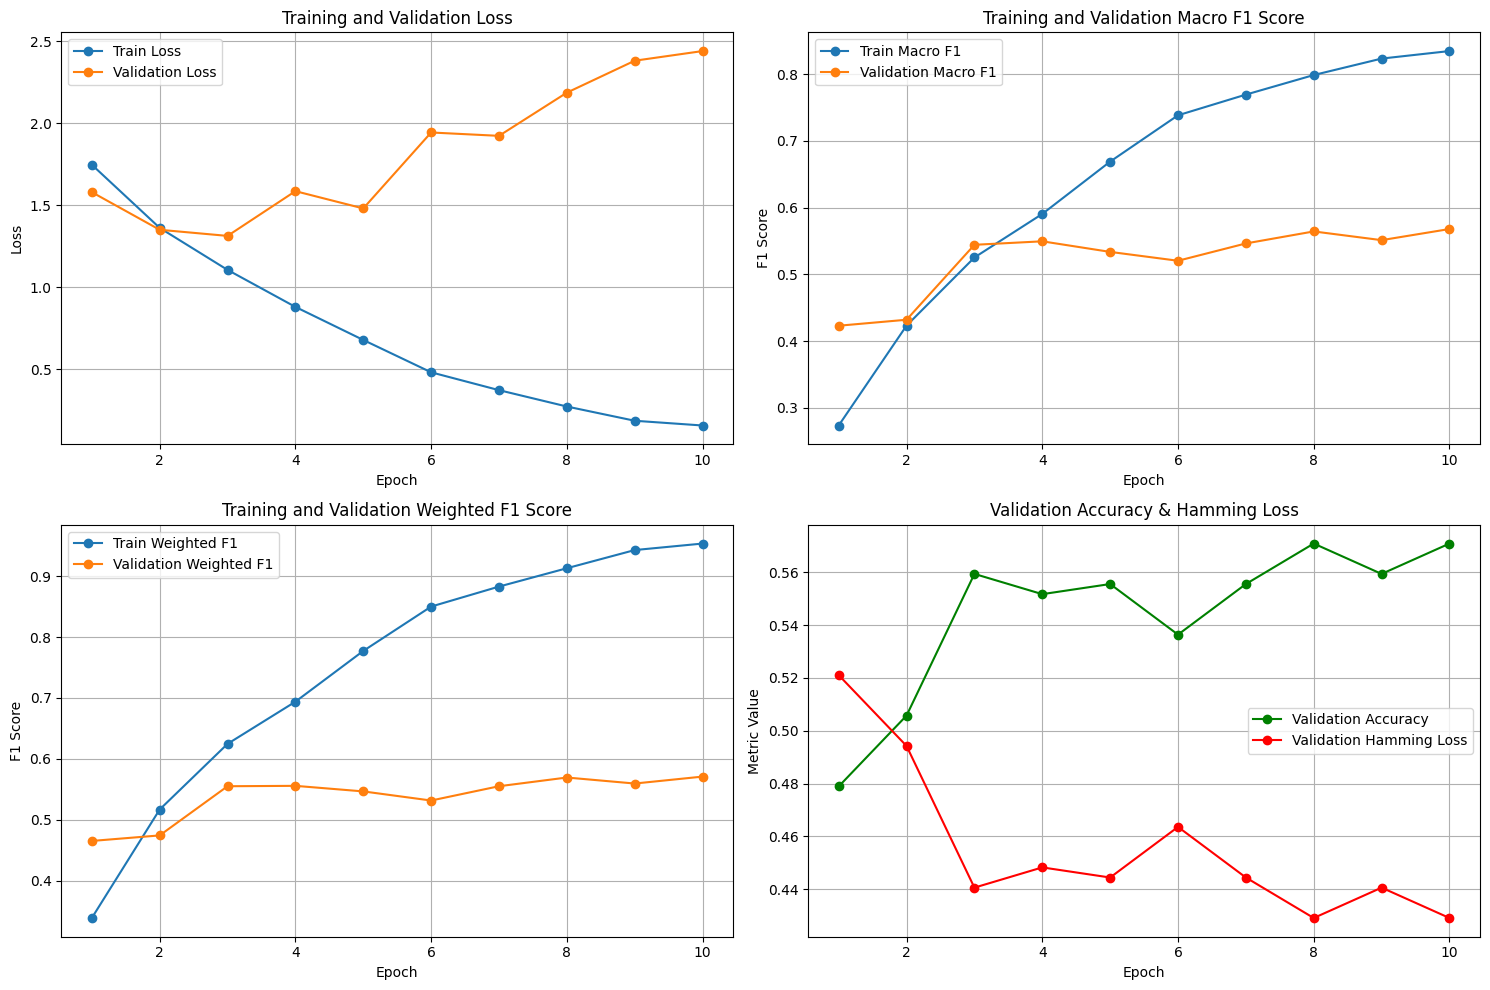

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/913131335.py:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
# --- Configuration for the Run ---
DATASET_CHOICE = 'anxiety'       # 'anxiety' or 'depression'
USE_SEPARATE_TEST_FILE = True    # True to use kaggle/.../test.json, False to split train
EPOCHS_TO_RUN = 10               # Lower epoch count for faster testing/debugging
BATCH_SIZE_TO_USE = 8           # Adjust based on GPU memory (4, 8, 16 are common)
VALIDATION_SPLIT = 0.1          # Used if USE_SEPARATE_TEST_FILE=True (splits train->train/val) or False (splits train->train/val/test)
TEST_SPLIT = 0.2                # Used only if USE_SEPARATE_TEST_FILE=False

# --- Run the Pipeline ---
# Clear memory before starting a heavy pipeline run
gc.collect()
if device == torch.device('cuda'):
    torch.cuda.empty_cache()

trained_model, trained_tokenizer, trained_label_encoder = run_pipeline(
    dataset_type=DATASET_CHOICE,
    use_test_set=USE_SEPARATE_TEST_FILE,
    val_split_ratio=VALIDATION_SPLIT,
    test_split_ratio=TEST_SPLIT,
    batch_size_override=BATCH_SIZE_TO_USE,
    num_epochs_override=EPOCHS_TO_RUN
)

# --- Post-Training ---
if trained_model and trained_tokenizer and trained_label_encoder:
    logger.info("Pipeline completed successfully. Model, tokenizer, and label encoder are available.")
    # Example: You can now use the 'predict' function if needed
    # sample_text = "This is making me so nervous"
    # sample_triples = "Cause-Effect: thinking about presentation causes nervousness\nMental State: nervous"
    # prediction = predict(trained_model, trained_tokenizer, trained_label_encoder, sample_text, sample_triples, device=device)
    # logger.info(f"Example Prediction: {prediction}")
else:
    logger.error("Pipeline did not complete successfully. Check logs for errors.")

# Optional: Clean up memory again after run
del trained_model, trained_tokenizer, trained_label_encoder
gc.collect()
if device == torch.device('cuda'):
    torch.cuda.empty_cache()

In [14]:
# Create a zip archive of the anxiety output folder
!zip -r /kaggle/working/anxiety_output.zip /kaggle/working/anxiety/output/knowledge_fusion/

# Optional: List the contents of the working directory to confirm the zip file was created
!ls -lh /kaggle/working/

  adding: kaggle/working/anxiety/output/knowledge_fusion/ (stored 0%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/test_report_best.txt (deflated 56%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/training_history.png (deflated 9%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/validation_report_best.txt (deflated 56%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/best_model.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 14%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/training_logs.csv (deflated 47%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/last_model.pt (deflated 14%)
  adding: kaggle/working/anxiety/output/knowledge_fusion/label_encoder.pkl (deflated 59%)
total 923M
drwxr-xr-x 3 root root 4.0K Apr 10 15:00 anxiety
-rw-r--r-- 1 root root 923M Apr 10 15:38 anxiety_output.zip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
